In [1]:
from cmath import nan
from PIL import Image
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
import cv2
import pandas as pd

In [2]:
"""
image registration and cropping functions
"""
def align_to_standard(img_dir, src_dir='src.jpeg'):
    src_color = cv2.imread(src_dir)
    sbj_color = cv2.imread(img_dir)

    src = cv2.cvtColor(src_color, cv2.COLOR_BGR2GRAY)
    sbj = cv2.cvtColor(sbj_color, cv2.COLOR_BGR2GRAY)
    
    orb_detector = cv2.ORB_create(2000)
    src_keypoints, src_descriptors = orb_detector.detectAndCompute(src, None)
    sbj_keypoints, sbj_descriptors = orb_detector.detectAndCompute(sbj,None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
    matches = list(matcher.match(sbj_descriptors, src_descriptors))
    
    matches.sort(key = lambda x: x.distance)
    matches = matches[:int(len(matches)*0.7)]

    # print(len(matches))
    # records matched keypoints' coordinates
    no_of_matches = len(matches)
    if (no_of_matches < 30):
        return []
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))

    for i in range(no_of_matches):
        p1[i, :] = sbj_keypoints[matches[i].queryIdx].pt
        p2[i, :] = src_keypoints[matches[i].trainIdx].pt
    
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    transformed_img = cv2.warpPerspective(sbj_color,
                        homography, (src.shape[1], src.shape[0]))
    return transformed_img

def crop_rotate_dir(img, og_file_dir, output_dir, angle = -1.5, left = 135, upper =85, right = 600, lower = 390):
    filename = og_file_dir.split('/')[-1]
    im = Image.fromarray(img)
    rotated = im.rotate(angle, expand = 1)
    im_final = rotated.crop((left, upper, right, lower))            
    im_final.save(output_dir+'/'+filename)

In [3]:
# count = 0
# for file in glob.glob('../check_regis/*.jpg'):
    
#     plt.figure(count + 10)
#     plt.imshow(cv2.imread(file))
#     plt.title(file)
    
#     plt.figure(count)
#     plt.imshow(align_to_standard(file))
#     plt.title('regis' + file)
#     count += 1

In [4]:
"""
input: filename of plate
output: pd df of the ground truth for that plate
"""
from typing import Tuple

all_labels = pd.read_csv('updated_ground_truth.csv')

def get_ground_truth(filename: str):
    id = filename.split('_')[-1].split('.')[0]
    this_labels = all_labels.loc[all_labels["destination_plate_bcode"]==int(id),['destination_well']].to_numpy()
    return this_labels

"""
gaussian_kernel_size: greater = blurring in larger neighborhood
gaussian_sigma: greater sigma = more blurring
adp_th_block_size needs to be odd: greater = looking at local intensities in a larger neighborhood
adp_th_const is a constant that is subtracted from the weighted mean; greater = effectively more noise reduction
"""
def load_and_preprocess_img(filename: str, gaussian_kernel_size: Tuple = (3,3), gaussian_sigma: float = 1.0, adp_th_block_size: int = 5, adp_th_const: int = 4):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_blurred = cv2.GaussianBlur(img, gaussian_kernel_size, gaussian_sigma)
    img_th = cv2.adaptiveThreshold(img_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, adp_th_block_size, adp_th_const)
    return img_th

"""
exclude wells with black background
"""
def exclude_wells(col_idx, row_idx):
    if ((col_idx == 2 or col_idx == 3) and row_idx == 12) or ((row_idx ==0 or row_idx == 15) and (col_idx==11 or col_idx ==12)) or (row_idx == 2 and col_idx==20):
        return True
    return False
"""
input: img or preprocessed img
output: conceptually a matrix of 16 x 24, each entry is the isolated well image
"""
def isolate_each_well(img_th):
    to_return = []
    y = img_th.shape[0] / 16
    x = img_th.shape[1] / 24
    for row in np.arange(0, img_th.shape[0], y):
        col_out = []
        for col in np.arange(0, img_th.shape[1], x):
            col_out.append(img_th[round(row):round(row+y),round(col):round(col+x)])
        to_return.append(col_out)
    return np.array(to_return, dtype=object)

"""
If one and only one particle is detected, report 1
If no particle detected, report 0
else: report -1 to indicate ambiguity
"""
def particle_detection_prediction(well_img):
    nb_components, arr = cv2.connectedComponents(well_img, connectivity=8)
    if nb_components - 1 == 1:
        pred = 1
    elif nb_components - 1 == 0:
        pred = 0
    else:
        pred = -1
    return pred

In [31]:
"""
Uses particle detection to predict whether or not bead is present.
Returns accuracy and a list of unsure well locations for each img (if particle_detection_prediction returns -1)
    which means that more than one particle is detected in the well
"""
from numpy import isnan

def melodys_pipeline(input_dir = '../first_batch_img', cropped_output_dir = '../cropped_first_batch_img'):
    # save aligned and cropped imgs to disk to avoid taking up too much memory
    for filename in glob.glob(input_dir+'/*.jpg'):
        # print(filename)
        img = align_to_standard(filename)
        if len(img) == 0: #image registration has issues
            continue
        # img = cv2.imread(filename)
        crop_rotate_dir(img, filename, output_dir=cropped_output_dir,left = 135, upper =85, right = 600, lower = 390)

    accuracy_list = []
    with_label = []
    no_label = []
    # unsure_dict = {}
    # read every image file from the input folder
    for filename in glob.glob(cropped_output_dir +'/*.jpg'):
        right = 0
        wrong = 0
        unsure = []
        labels = get_ground_truth(filename)
        if len(labels) == 0:
            no_label.append(filename)
            continue
        with_label.append(filename)
        img_th = load_and_preprocess_img(filename, (3,3), 1.0, 5, 4)
        well_imgs = isolate_each_well(img_th)
        for row in range(well_imgs.shape[0]):
            for col in range(well_imgs.shape[1]):
                if exclude_wells(col, row):
                    continue
                well = np.array(well_imgs[row,col])
                # pred = particle_detection_prediction(well) # comment this if using only num of val in thresholded img and uncomment the following line
                pred = len(np.unique(well)) - 1 
                if pred != -1:
                    #get truth
                    well_id = chr(ord('A') + row) + str(col + 1)
                    if well_id in labels:
                        truth = 1
                    else:
                        truth = 0
                        
                    if pred == truth:
                        right += 1
                    else:
                        wrong += 1
                else:
                    unsure.append([row, col])
        accuracy_list.append(right / (right + wrong + len(unsure)))
        # unsure_dict[filename] = len(unsure)
    return accuracy_list, with_label, no_label #, unsure_dict

In [32]:
accuracies, with_label, no_labels = melodys_pipeline()

In [38]:
print(len(no_labels))

16


In [39]:
print(len(glob.glob('../first_batch_img/*.jpg')))

606


(array([  1.,   0.,   3.,   1.,   3.,   6.,  15.,  16.,  68., 448.]),
 array([0.4403183 , 0.49628647, 0.55225464, 0.60822281, 0.66419098,
        0.72015915, 0.77612732, 0.83209549, 0.88806366, 0.94403183,
        1.        ]),
 <BarContainer object of 10 artists>)

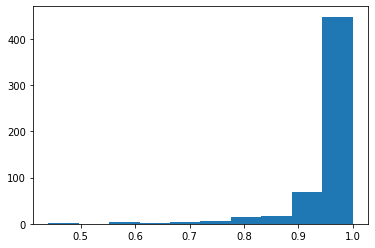

In [33]:
plt.hist(accuracies)

In [34]:
print(np.sum(np.array(accuracies)>0.9)/len(accuracies))

0.8983957219251337


In [37]:
print(len(with_label))

561


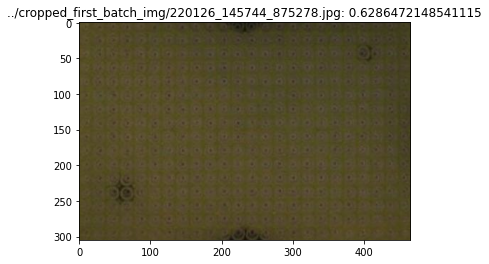

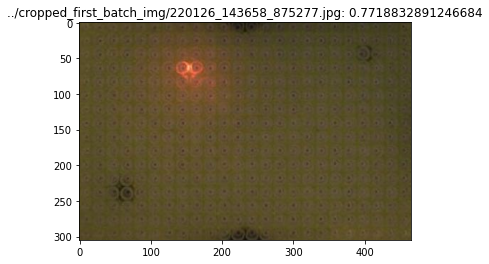

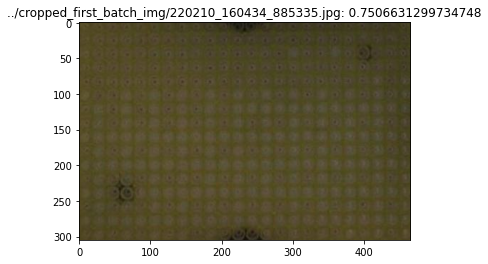

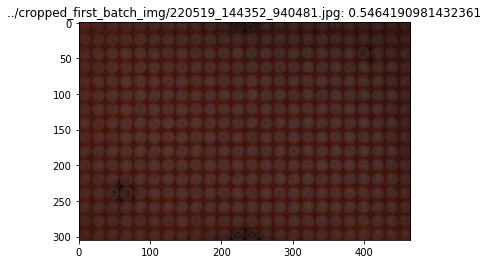

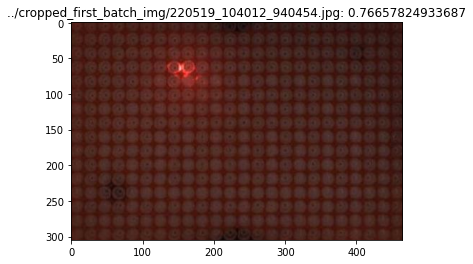

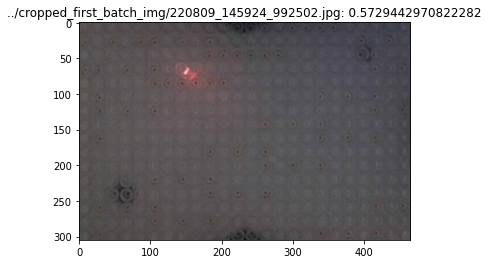

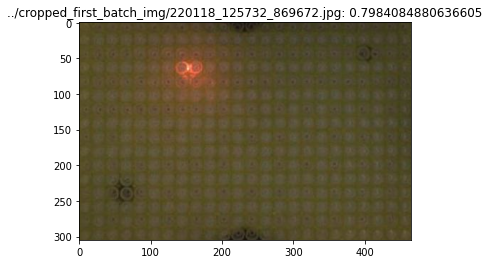

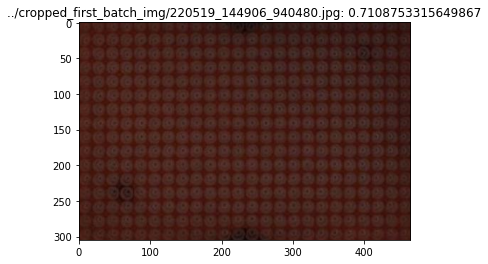

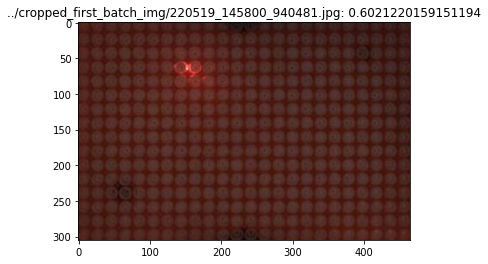

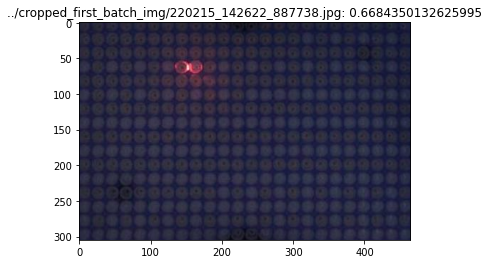

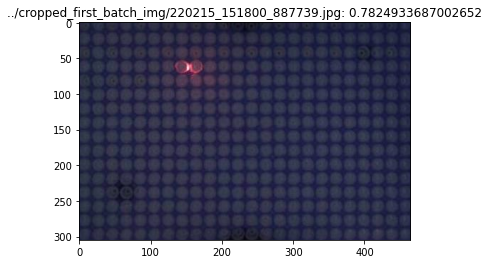

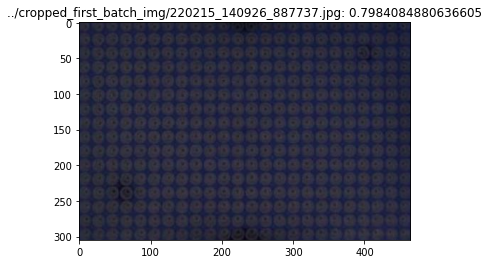

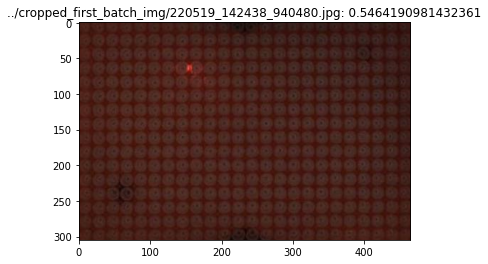

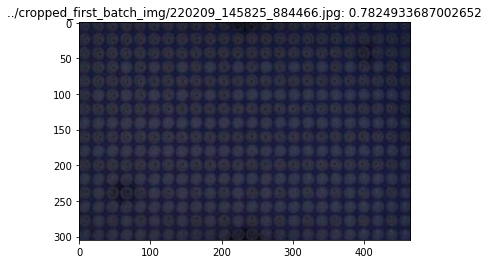

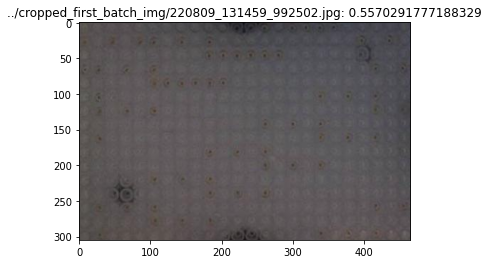

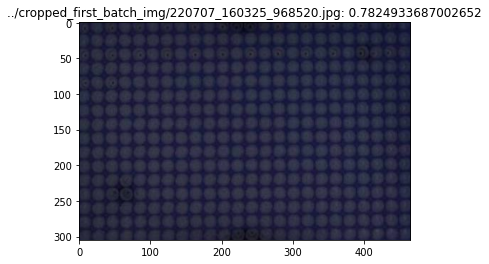

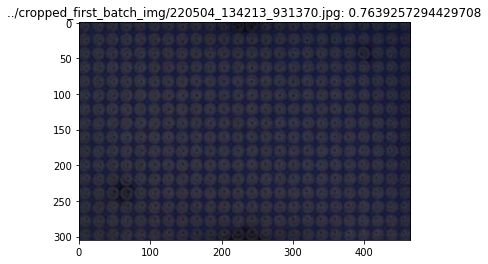

In [25]:
bad_img = np.where(np.array(accuracies)<0.8)
to_see = np.array(with_label)[bad_img]
count = 0
for idx, img in enumerate(to_see):
    
    plt.figure(count)
    plt.imshow(cv2.imread(img))
    plt.title(img + ': ' +str(accuracies[bad_img[0][idx]]))
    count+=1
    

# total_red = 0
# bad_red = 0
# for idx, img in enumerate(with_label):
#     if '220831' in img:
#         total_red += 1
#         if img in to_see:
#             bad_red += 1
#             print(img)
# print(total_red, bad_red)
# plt.figure(1)
# plt.imshow(cv2.imread('../first_batch_img/220519_144906_940480.jpg'))
# plt.figure(2)
# plt.imshow(align_to_standard('../first_batch_img/220519_144906_940480.jpg'))
# print(to_see[6])
# plt.figure(3)
# plt.imshow(cv2.imread(to_see[5]))
# labels = get_ground_truth(to_see)
# well_imgs = isolate_each_well(load_and_preprocess_img(to_see, (3,3), 1.0, 5, 4))
# for row in range(len(well_imgs)):
#     for col in range(len(well_imgs[0])):
#         print(chr(ord('A') + row) + str(col + 1))
#         print(len(np.unique(well_imgs[row,col])))

In [35]:
np.mean(accuracies)

0.9606802933374942

In [11]:
# df = pd.read_csv('small_val_labels.csv')
# df.loc[(df['col_id']==1) & (df['row_id']==1),'label'].tolist()

In [12]:
# def melodys_toy_data_pipeline(img_dir):
#     accuracy_list = []
#     unsure_dict = {}
#     # read every image file from the input folder
    
#     right = 0
#     wrong = 0
#     unsure = []
#     labels = pd.read_csv('small_val_labels.csv')
#     # plt.figure(0)
#     # plt.imshow(cv2.imread(img_dir,0))
#     img_th = load_and_preprocess_img(img_dir, (3,3), 1.0, 5, 4)
#     # plt.figure(999)
#     # plt.imshow(img_th)
#     well_imgs = isolate_each_well(img_th)
#     for row in range(well_imgs.shape[0]):
#         for col in range(well_imgs.shape[1]):
#             truth = labels.loc[(labels['col_id']==col) & (labels['row_id']==row),'label'].tolist()
#             if truth == [] or np.isnan(truth):
#                 continue
#             truth = truth[0]
#             if exclude_wells(col, row):
#                 continue
#             well = np.array(well_imgs[row,col])
#             # print(cv2.connectedComponents(well))
#             pred = particle_detection_prediction(well)
#             # pred = len(np.unique(well)) - 1
#             # plt.figure((row+1)*(col+1))
#             # plt.title(str(truth))
#             # plt.imshow(well)
#             if pred != -1:
#                 if pred == truth:
#                     right += 1
#                 else:
#                     wrong += 1
#             else:
#                 unsure.append([row, col])
#     accuracy_list.append(right / (right + wrong + len(unsure)))
#     unsure_dict[img_dir] = len(unsure)
#     return accuracy_list, unsure_dict

In [13]:
# melodys_toy_data_pipeline('220118_122237_869669.jpeg')